In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Houses Price") \
    .getOrCreate()

In [2]:
# Carichiamo il data set
trainDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/train.csv', header = 'True', inferSchema='True', nullValue='NA')
testDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/test.csv', header = 'True', inferSchema='True', nullValue='NA')

In [3]:
trainDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [4]:
# verifichiamo la presenza di valori nulli
df = trainDF.toPandas()

featuresNull = df.isna().sum().sort_values( ascending=False )
print(featuresNull)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64


Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

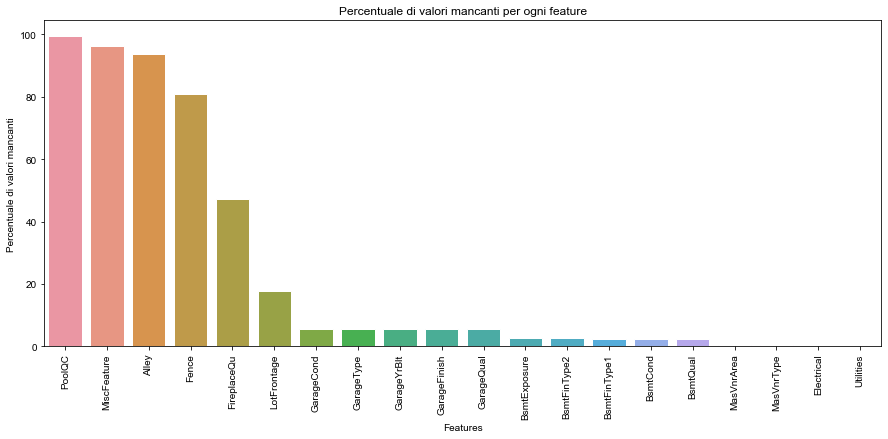

In [5]:
# calcolo la percentuale di dati mancanti per ogni feature

import seaborn as sns
import matplotlib.pyplot as plt

missing_ratio = ( ( df.isna().sum() / len(df)) * 100 ).sort_values(ascending=False)

plt.subplots(figsize=(15, 6))
sns.set(font_scale = 1)
plt.xticks(rotation='90')
sns.barplot(x=missing_ratio.index[:20], y=missing_ratio[:20]) #prendo le prime 20 per una migliore visualizzazione
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [6]:
# cancelliamo le features che hanno una percentuale di valori nulli sopra 80% (1168)

theshold = 0.8
n_values_not_null = len(df) * (1 - theshold)
df_clean = df.dropna(axis='columns', thresh=n_values_not_null, inplace=False)

Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

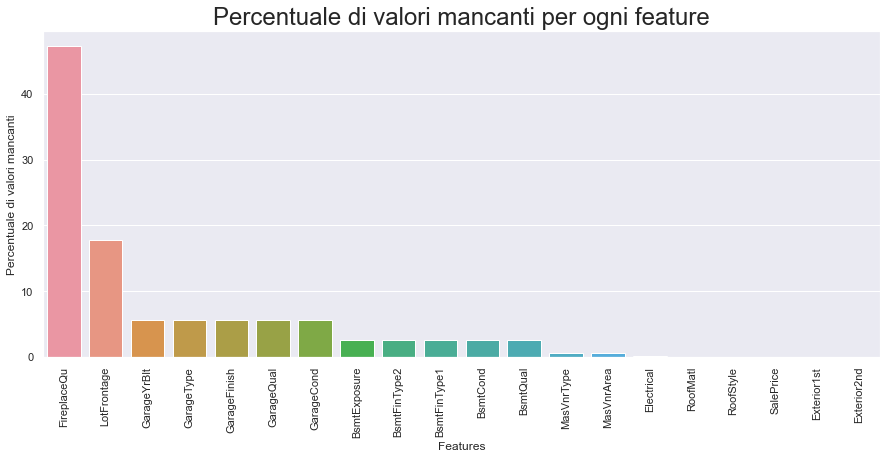

In [7]:
missing_ratio_2 = ( ( df_clean.isna().sum() / len(df_clean)) * 100 ).sort_values(ascending=False)

plt.subplots(figsize=(15, 6))
sns.set(font_scale = 2)
plt.xticks(rotation='90')
sns.barplot(x=missing_ratio_2.index[:20], y=missing_ratio_2[:20]) #prendo le prime 20 per visualizzarle meglio
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

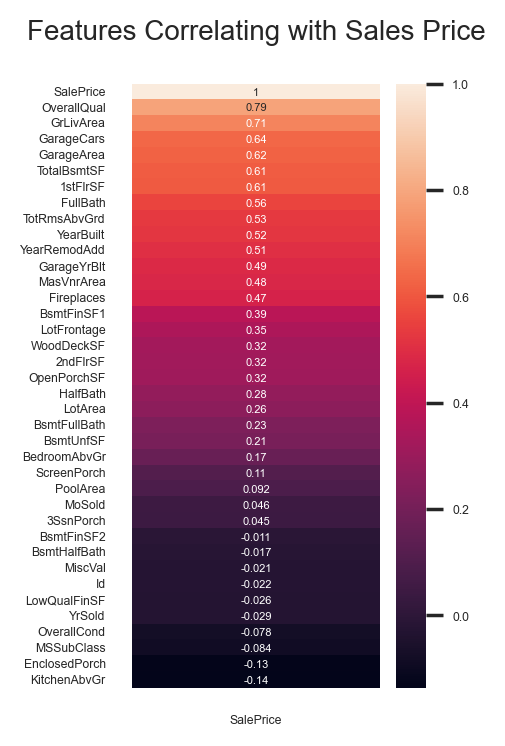

In [8]:
# vediamo la correlazione solo con il prezzo di vendita

corrSP = df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(2, 4), dpi = 200) 
sns.set(font_scale = 0.4)

sns.heatmap(corrSP, annot=True, annot_kws={"fontsize":4},).set_title('Features Correlating with Sales Price', fontdict={'fontsize':10}, pad=16);

In [9]:
# prendiamo le feature che hanno un valore di correlazione >= 0.5 ed eliminiamo la colonna SalePrice che avrà valore 1 
featuresSelect = corrSP['SalePrice'][ corrSP['SalePrice'] >= 0.5].drop('SalePrice')

print(featuresSelect)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64
